# 2.4 [Implementing Gaussian process in Python](https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/main/CH02/01%20-%20Gaussian%20processes.ipynb)

### 2.4.1 Setting up the training data

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
def forrester_1d(x):
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [4]:
torch.manual_seed(21)
train_x = torch.rand(size=(3, 1)) * 6 - 3  # x 限制在 [-3, 3]
train_y = forrester_1d(train_x)

train_x, train_y

(tensor([[-0.1586],
         [ 0.6816],
         [-2.9276]]),
 tensor([0.8593, 1.1243, 0.5136]))

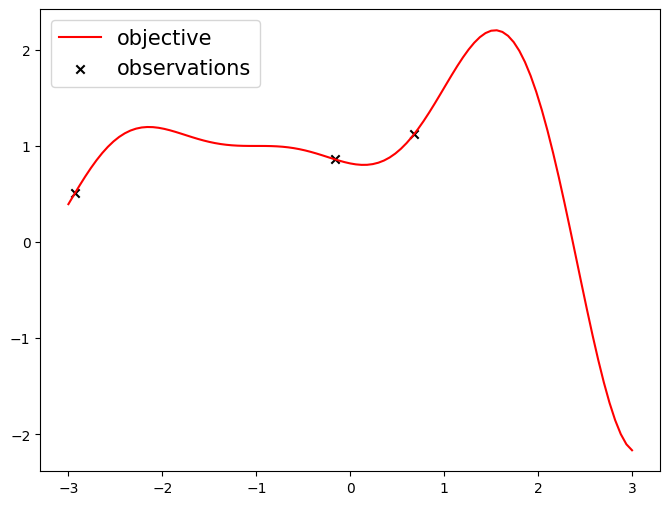

In [8]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

plt.figure(figsize=(8, 6))
plt.plot(xs, ys, label='objective', color='red')
plt.scatter(train_x, train_y, marker='x', color='k', label='observations')
plt.legend(loc='best', fontsize=15)
plt.show()

### 2.4.2 Implementing a Gaussian process class

In [9]:
import gpytorch


class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()  # 均值函数定义。以先验形式输出零均值预测
        self.covar_module = gpytorch.kernels.RBFKernel()  # 协方差函数定义。径向基函数内核--RBF kernel

    def forward(self, x):
        # 不是按顺序将结果传递给不同的模块，而是同时将输入传递给均值函数和协方差函数。
        # The output of these modules is then combined to create an MVN distribution.

        # 由于我们有一个均值函数和一个协方差函数，我们只需在输入 x 上调用它们来计算均值和协方差预测。
        # 最后，我们需要返回的是一个 MVN 分布

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

使用 GP 的优点之一是，即使没有任何数据，我们仍然可以利用先验均值函数中包含的知识进行预测。

## 2.4.3 Making predictions with a GP

In [22]:
# declare the GP
lengthscale = 1  # 长度尺度 
noise = 1e-4  # 噪声方差

likelihood = gpytorch.likelihoods.GaussianLikelihood()
# 为了在没有任何训练数据的情况下初始化 GP 对象，我们将 None 作为训练特征 (train_x) 和标签 (train_y) 传递。
model = BaseGPModel(None, None, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## 2.4.4 Visualizing predictions by a Gaussian process

In [23]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))  # 这里似然函数将噪声纳入GP
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()  # 95% CI

    torch.manual_seed(21)
    samples = predictive_distribution.sample(torch.Size([5]))  # 采样 5 次

In [24]:
predictive_upper

tensor([2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001])

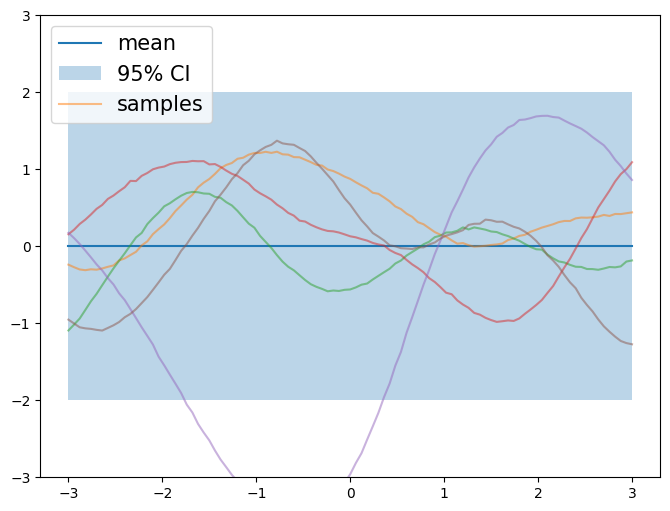

In [25]:
plt.figure(figsize=(8, 6))

plt.plot(xs, predictive_mean.detach(), label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.ylim(-3, 3)

plt.legend(fontsize=15)
plt.show()

我们之前的 GP 产生的均值函数恒定为零，并且我们的 95% CI 是恒定的。这是可以预料的。

均值和置信区间只是对期望的测量：它们表示我们对可能发生的情况的许多不同实现的预测的平均行为。然而，当我们绘制单个样本时，我们发现每个样本都有一个非常复杂的形状，而且根本不是恒定的。所有这一切都表明，虽然我们在任何点的预测的预期值都为零，但它可以取的值范围很广。这表明 GP 可以以灵活的方式对复杂的非线性行为进行建模

In [26]:
# 接下来用训练数据初始化 model
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [27]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    torch.manual_seed(21)
    samples = predictive_distribution.sample(torch.Size([5]))

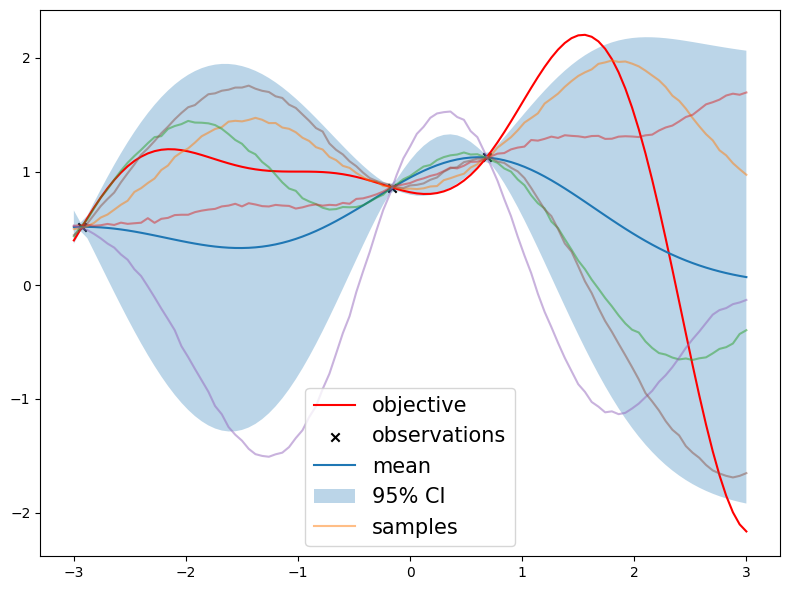

In [29]:
plt.figure(figsize=(8, 6))

plt.plot(xs, ys, label="objective", c="r")
plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

plt.plot(xs, predictive_mean, label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

## 2.4.5 Going beyond one-dimensional objective functions

In [30]:
# 创建二维数据
train_x = torch.tensor([[0.0, 0.0], [1.0, 2.0], [-1.0, 1.0]])

train_y = torch.tensor([0.0, -1.0, 0.5])

In [31]:
grid_x = torch.linspace(-3, 3, 101)  # 1d

grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")  # 2d
xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten()]).transpose(-1, -2)

In [32]:
xs

tensor([[-3.0000, -3.0000],
        [-3.0000, -2.9400],
        [-3.0000, -2.8800],
        ...,
        [ 3.0000,  2.8800],
        [ 3.0000,  2.9400],
        [ 3.0000,  3.0000]])

In [33]:
# declare the GP
lengthscale = 1
noise = 1e-4

# 不需要修改 BaseGPModel 类或任何预测代码
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

绘制预测平均值的热图和预测标准差的另一热图。虽然标准差并不完全是 95% CI，但这两个对象本质上确实量化了同一件事：我们对函数值的不确定性。

In [35]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev  # 提取标准差

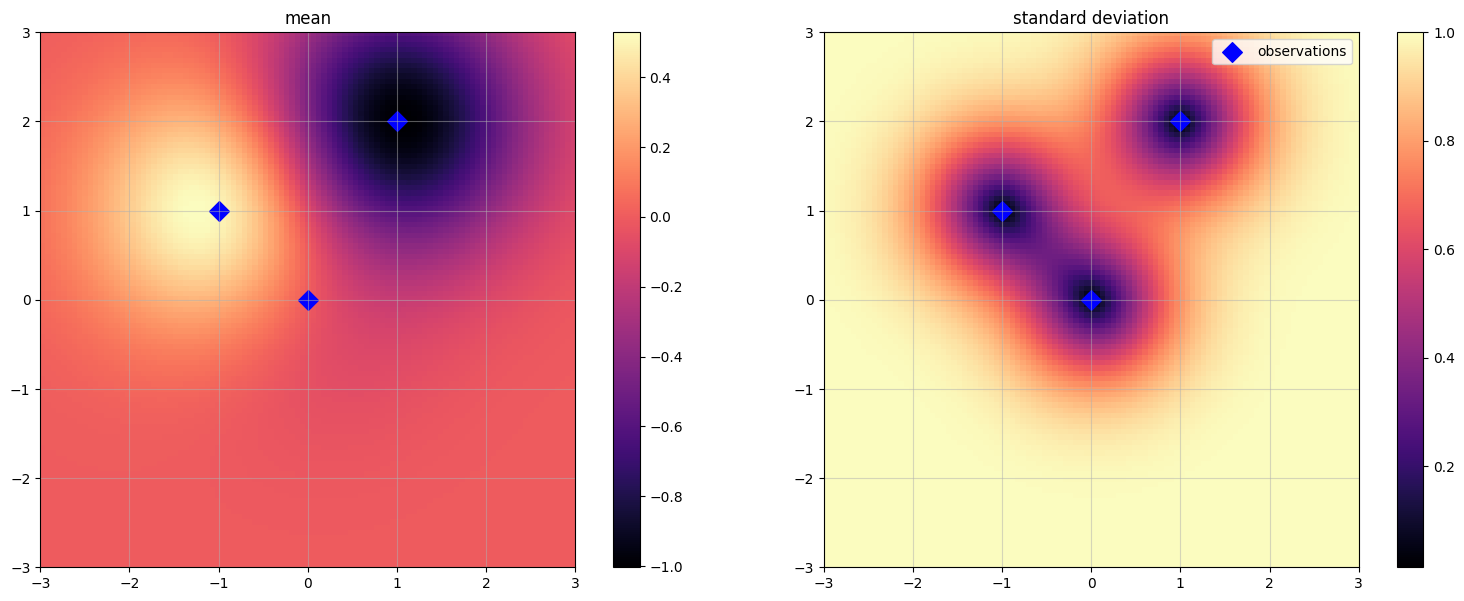

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# The first heat map for the predictive mean
c = ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
    cmap="magma"
)
plt.colorbar(c, ax=ax[0])
ax[0].scatter(train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100)
ax[0].set_title("mean")
ax[0].grid(alpha=0.5)

# The second heat map for the predictive standard deviation
c = ax[1].imshow(
    predictive_stddev.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
    cmap="magma"
)
plt.colorbar(c, ax=ax[1])
ax[1].scatter(
    train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100, label="observations"
)
ax[1].set_title("standard deviation")
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

我们看到一维情况下的情况也扩展到了这个例子：
- 左侧面板显示我们的平均预测与我们的训练数据一致：左侧的明亮斑点对应于 (–1, 1)，它有值为 0.5，而右侧的深色斑点对应于 (1, 2)，其值为 –1（我们在 (0, 0) 处的观察值为 0，这也是先验平均值，因此它不像其他两个那样在左侧面板中明显指出）。
- 我们的不确定性（通过预测标准差来衡量）在训练数据中的三个点周围接近于零，如右图所示。远离这些数据点，标准差平滑地增加至归一化最大不确定性 1.
- 这意味着当我们进入更高维度时，GP 的所有优良特性（例如平滑插值和不确定性量化）都会被保留。